# Lab 4: Building a Spotify Song Classifier with KNNs and Decision Trees

### Michelle Yiv

#### Collaborators: Karol Paya and Naomi Moraes
**Classify by genres**. In this lab, you will build machine learning genre classifiers using a dataset of Spotify tracks. Your goal is to train a model that can distinguish between two selected genres based on various audio features such as danceability, energy, valence, tempo, and more.

We'll follow the familiar workflow of data exploration -> preprocessing -> model training -> evaluation

In [41]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

### Step 1: The data
We'll focus on two genres: Blues and Jazz (what’s the difference, anyway??).

Both genres have rich musical histories, but they differ in structure:

- Blues tends to have simpler chord progressions and a strong emotional expression.
- Jazz often involves complex improvisation and more varied rhythms.

But can a machine really tell them apart just by looking at numerical audio features? That’s what we’ll find out!

In this step, you will:
- Load the dataset
- Extract only blues and jazz for classification

In [2]:
# Read in the data
spotify_data = pd.read_csv('/courses/EDS232/Data/spotify_dat.csv')

# Print the data types in spotify_data
print(f"The data types of each column: {spotify_data.dtypes}")

# Filter down to two genres
blues_data = spotify_data[spotify_data['genres'] == 'blues']
jazz_data = spotify_data[spotify_data['genres'] == 'jazz']

# Combine both genres into one dataset
combined_data = pd.concat([blues_data, jazz_data])

# Rename 'genres' column to 'genre' for clarity
combined_data = combined_data.rename(columns={"genres": "genre"})

# Confirm changes
combined_data['genre'].unique()

The data types of each column: id                   object
name                 object
album                object
album_id             object
artists              object
artist_ids           object
track_number          int64
disc_number           int64
explicit               bool
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration_ms           int64
time_signature      float64
year                  int64
release_date         object
genres               object
dtype: object


array(['blues', 'jazz'], dtype=object)

## Step 2: Data Exploration
Now that we have Blues and Jazz as our two genres, it's time to explore the data and look for patterns in the audio features.

Let's investigate:
- Which features are available?
- How strongly these features correlate with each other.
- How different genres distribute across  sample features: danceability 

In this step, we will:
- Filter out non-numeric columns before the plotting
- Visualize feature correlations using a heatmap.
- Examine key feature distributions with histograms to see if genres behave differently.


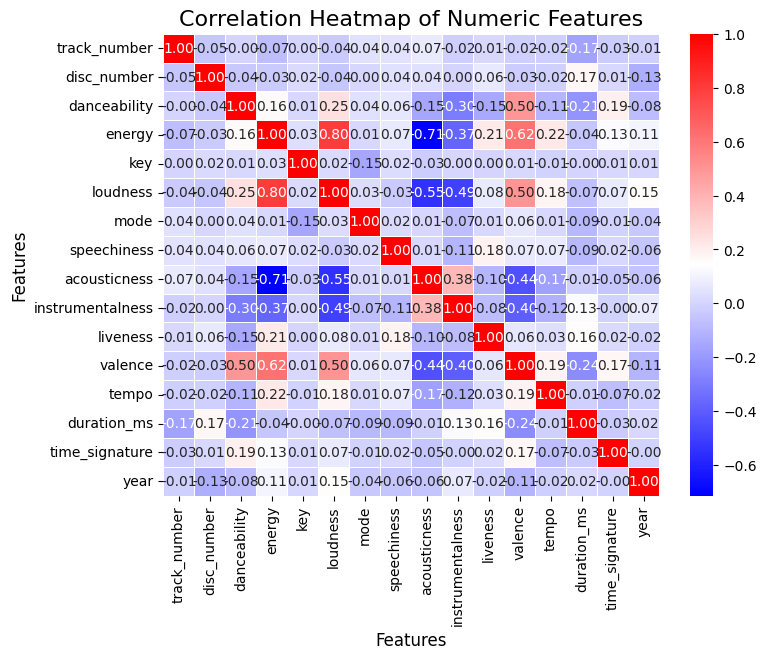

In [29]:
# Exclude non-numeric columns but keep 'genre' for grouping
numeric_features = combined_data.select_dtypes(include=['number']).copy() # Make a copy 
numeric_features.loc[:,'genre'] = combined_data['genre'] # Modify df, not the view from dtypes

# Correlation heatmap

# Make correlation matrix
correlation_matrix = numeric_features.drop('genre', axis =1).corr()

# Initialize figure
plt.figure(figsize=(8,6))

# Plot correlation
sns.heatmap(correlation_matrix, annot=True, cmap="bwr", fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Features', fontsize=16)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Features', fontsize=12)

plt.show()

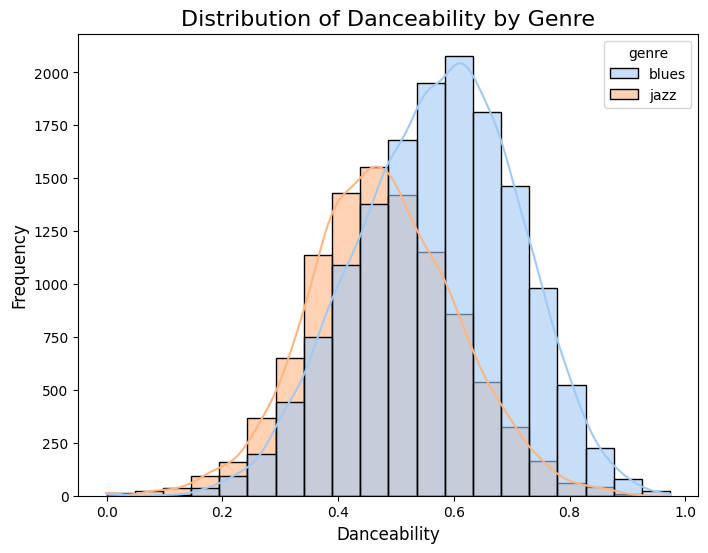

In [31]:
# Histogram of Danceability

plt.figure(figsize=(8, 6))

sns.histplot(data=numeric_features, x='danceability', hue='genre', kde=True, bins=20, palette='pastel', alpha=0.6)

plt.title('Distribution of Danceability by Genre', fontsize=16)
plt.xlabel('Danceability', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.show()

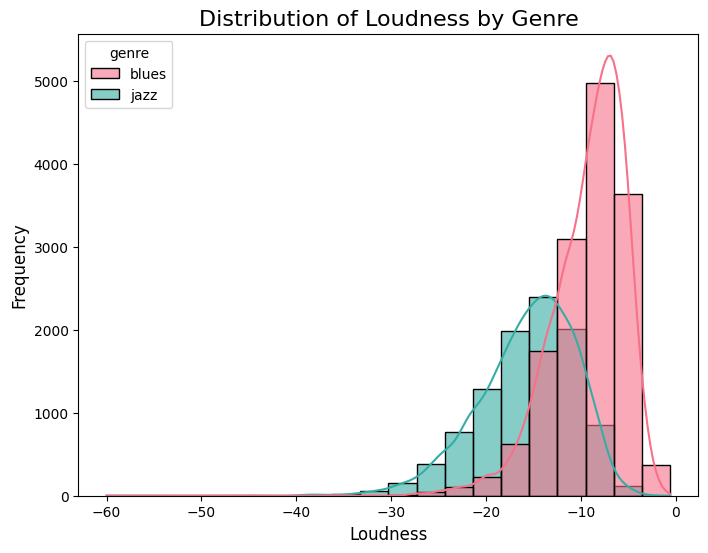

In [38]:
# Histogram of Loudness

plt.figure(figsize=(8, 6))

sns.histplot(data=numeric_features, x='loudness', hue='genre', kde=True, bins=20, palette='husl', alpha=0.6)

plt.title('Distribution of Loudness by Genre', fontsize=16)
plt.xlabel('Loudness', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.show()

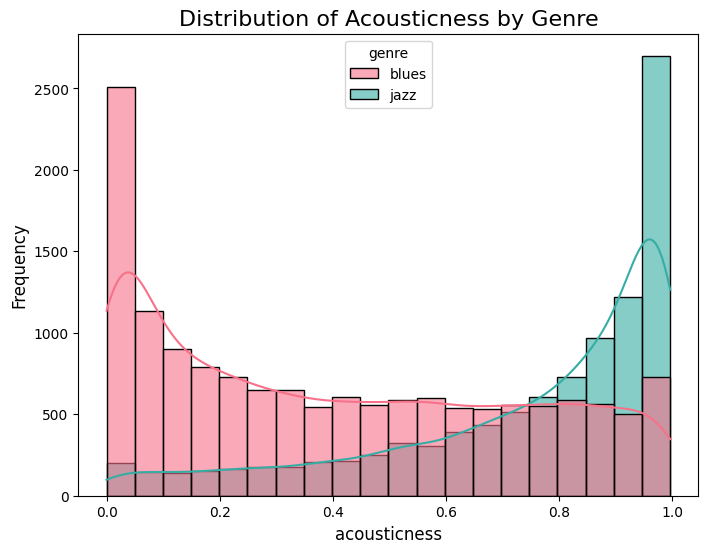

In [21]:
# Examing other features by genre
# Histogram of Acousticness

plt.figure(figsize=(8, 6))

sns.histplot(data=numeric_features, x='acousticness', hue='genre', kde=True, bins=20, palette='husl', alpha=0.6)

plt.title('Distribution of Acousticness by Genre', fontsize=16)
plt.xlabel('acousticness', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.show()

### Step 3: Check for class imbalance
An unequal distribution between the target classes can cause issues for our classifiers, so we'll need to check for that. A commonly used guideline for class imbalance is:

- Slight Imbalance (Less than 1.5:1) → Generally okay; no need for balancing.
- Moderate Imbalance (Between 1.5:1 and 3:1) → Might cause some bias; balancing can help.
- Severe Imbalance (More than 3:1) → Strongly affects model performance; balancing is usually necessary.

In [23]:
# Print counts of each genre
class_counts = numeric_features['genre'].value_counts()

# Calculate ratio of majority to minority class
class_ratio = class_counts.max() / class_counts.min()

# Print class distribution and ratio
print(f"\nThe ratio of the majority class to the minority class is: {class_ratio:.2f}")
print(f"Class counts:\n {class_counts}")


The ratio of the majority class to the minority class is: 1.48
Class counts:
 blues    14811
jazz     10023
Name: genre, dtype: int64


Given this result, should we be worried about the imbalance?

As the ratio of majority to minority class is 1.48, it falls in the guidelines as a 'Slight Imbalance', meaning it is usually okay to proceed and balancing is not needed. It is close to the threshold for Moderate imbalance (meaning that some balancing can help), however its ratio should not effect the model's performance. This should be taken into consideration however.

### Step 4: Preprocessing
We need to ensure all the variables we use are numerical so the models can process them. First we'll drop all the variables that are not numeric or the target. Then we'll use a sklearn utility, `LabelEncoder()` to encode our categorical target variable into numerical values. Print the first five values of your encoded labels.

In [5]:
# Define the features (drop columns that are not numeric or target)
X = numeric_features.select_dtypes(include=['number'])

# Set the target variable as 'genre'
y = numeric_features['genre']

# Encode the target variable ('label') using label encoding
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Print first five values of encoded labels
print("Encoded labels for the first five samples:", y_encoded[:5])

Encoded labels for the first five samples: [0 0 0 0 0]


Good, now we'll do our data splitting and scaling.  Let's go with an 80/20 split this time.

In [6]:
# Split data into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform only the training set
X_train_scaled = scaler.fit_transform(X_train)

# Use the same scaler to transform the test set
X_test_scaled = scaler.transform(X_test)

### Step 5: Train the models
OK, now it's time to build our models and assess the training accuracy. We'll use the default of k = 5 for the KNN model.

In [25]:
# Initialize models
knn = KNeighborsClassifier(n_neighbors=5)
dt = DecisionTreeClassifier(random_state=42)

# Train (fit) both models
knn.fit(X_train_scaled, y_train) # KNN model
dt.fit(X_train_scaled, y_train) # dt model

# Predictions on training data
knn_y_train_pred = knn.predict(X_train_scaled) 
dt_y_train_pred = dt.predict(X_train_scaled)

# Compute training accuracy
knn_train_accuracy = accuracy_score(y_train, knn_y_train_pred)
dt_train_accuracy = accuracy_score(y_train, dt_y_train_pred)

# Print training accuracy for both models
print(f"KNN Training Accuracy: {knn_train_accuracy:.3f}")
print(f"Decision Tree Training Accuracy: {dt_train_accuracy:.3f}")

KNN Training Accuracy: 0.921
Decision Tree Training Accuracy: 1.000


### Step 6: Evaluate models
OK, now let's go ahead and predict on the test data to see how well our models do at predicting the genre of unseen tracks.

In [8]:
# Make predictions
knn_pred = knn.predict(X_test_scaled)
dt_pred = dt.predict(X_test_scaled)

# Evaluate prediction accuracy
knn_accuracy = accuracy_score(y_test, knn_pred)
dt_accuracy = accuracy_score(y_test, dt_pred)

#Print prediction accuracy for both models
print(f"KNN Test Accuracy: {knn_accuracy:.3f}")
print(f"Decision Tree Test Accuracy: {dt_accuracy:.3f}")

KNN Test Accuracy: 0.892
Decision Tree Test Accuracy: 0.853


### Step 7: Visualizing Model Performance
Now that we have evaluated our models on unseen data, let’s compare their performance by visualizing the training vs. test accuracy.  We'll look for signs of overfitting by plotting the training accuracy and test accuracy for both k-NN and Decision Trees.

Create a bar chart that compares the training accuracy and test accuracy for k-NN and Decision Trees. Your plot should clearly display:

- The training and test accuracy for both models.
- Properly labeled axes and a title.
- A legend to differentiate training and test accuracy.
- Accuracy values displayed on top of each bar.

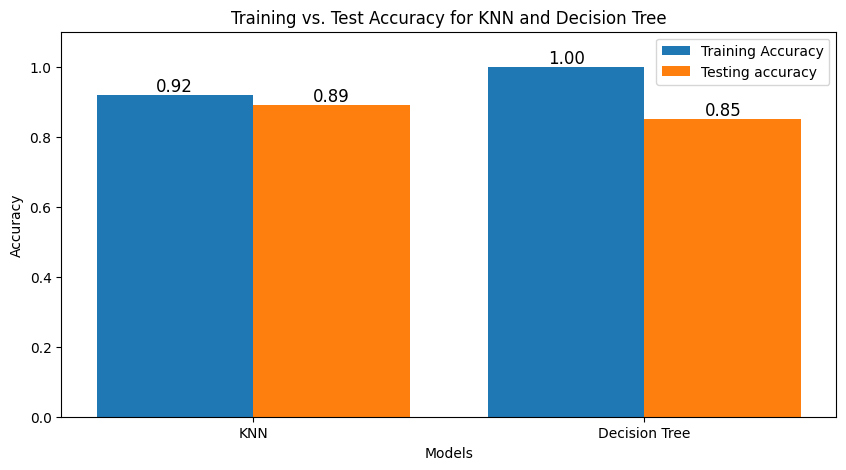

In [39]:
# Numbers of pairs of bars you want
N = 2

# Data on X-axis

# Specify the values of blue bars (height)
blue_bar = (0.92, 1.0)
# Specify the values of orange bars (height)
orange_bar = (0.89, 0.85)

# Position of bars on x-axis
ind = np.arange(N)

# Figure size
plt.figure(figsize=(10,5))

# Width of a bar 
width = 0.4      

# Plotting
plt.bar(ind, blue_bar , width, label='Training Accuracy')
plt.bar(ind + width, orange_bar, width, label='Testing accuracy')

# Adding data labels explicitly
plt.text(ind[0], blue_bar[0] + 0.01, f"{blue_bar[0]:.2f}", ha='center', fontsize=12)
plt.text(ind[1], blue_bar[1] + 0.01, f"{blue_bar[1]:.2f}", ha='center', fontsize=12)
plt.text(ind[0] + width, orange_bar[0] + 0.01, f"{orange_bar[0]:.2f}", ha='center', fontsize=12)
plt.text(ind[1] + width, orange_bar[1] + 0.01, f"{orange_bar[1]:.2f}", ha='center', fontsize=12)


plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Training vs. Test Accuracy for KNN and Decision Tree')

# xticks()
# First argument - A list of positions at which ticks should be placed
# Second argument -  A list of labels to place at the given locations
plt.xticks(ind + width / 2, ('KNN', 'Decision Tree'))

# Finding the best position for legends and putting it
plt.legend(loc= 'best')
plt.ylim(0, 1.1)  # Keep the range between 0 and 1 for better visibility
plt.show()

Which model does a better job of generalizing to unseen data? How do you know?
Does it appear that either of the models are overfitting? Why?

The KNN model does a better job at generalizing unseen data, as seen by its higher accuracy on testing data compared to the decision tree (0.89 > 0.85), and that the gap between training and test accuracies are smaller in KNN vs. Decision trees. (differeces KNN vs DT: 0.03 < 0.15). The Decision tree model appears to be overfitting as the training accuracy is at 100%, meaning that the model likely memorized instead of learned about trends in the training data.

### Bonus question
In the workflow above, we used the default parameter values of k = 5 for the KNN model, and maxdepth = None for the Decision Tree. Choose one of the models and see if you can improve test performance by optmizing its corresponding parameter value.

In [43]:
# Set up a range of max_depth values to try
param_grid = {'max_depth': range(1, 11)}  # Testing depths from 1 to 10

# Initialize the Decision Tree model
dt = DecisionTreeClassifier(random_state=42) # Set seed

# Perform grid search with CV
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='accuracy') # Remember to load this library

# Fit the model to find the best max_depth
grid_search.fit(X_train_scaled, y_train)

# Best max_depth and the corresponding test accuracy
best_max_depth = grid_search.best_params_['max_depth'] 
best_dt = grid_search.best_estimator_ # Get the best decision tree model

# Evaluate the optimized Decision Tree on the test set
optimized_dt_pred = best_dt.predict(X_test_scaled)
optimized_dt_accuracy = accuracy_score(y_test, optimized_dt_pred)

# Print the results
print(f"Best max_depth: {best_max_depth}")
print(f"Optimized Decision Tree Test Accuracy: {optimized_dt_accuracy:.4f}")

Best max_depth: 8
Optimized Decision Tree Test Accuracy: 0.8792
